# Script to perform QSAR modelling by means of canonical correlation method
### Additionally the script calculates aquatic toxicity levels based on predicted data
### It is required to provide endpoints in log(1/EC50) [mmol/L] or [mg/L] units. 

### If your endpoint is provided in log(1/EC50) [mmol/L] units, the script will transform the data to [mg/L] provided that your dataset includes MOLECULAR WEIGTHS of each compound as a separate sheet in the data tabe being loaded by the script. If you have any problems please refer to the data.xlsx file.


# Before you run the script, please make sure you have installed all necessary libraries from the requirements.txt file. 
### You can install them simply by running command "pip install -r requirements.txt" from the cmd or terminal on your PC/Mac

# Import libraries

In [1]:
import pandas as pd
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import warnings
import numpy as np
from sklearn import metrics
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Import functions

In [2]:
def one_to_x(X,n=3):
    import numpy as np
    row_val = X.shape[0]
    train_split = []
    val_split = []  
    for row in range(0, row_val):
        if ((row%n) < n-1):
            train_split.append(row)
        else:
            val_split.append(row)
    last_train = np.max(train_split)
    last_val = np.max(val_split)
    if (np.max(train_split) < np.max(val_split)):
        train_split.pop()
        val_split.pop()
        train_split.append(last_val)
        val_split.append(last_train)
        
    return train_split, val_split

def calculate_mg_l(log_ec50, mw):
    return (1/np.power(10, log_ec50))*mw

def calculate_acute_class(mg_l):
    if (mg_l <= 1):
        return 1
    elif (1 < mg_l <= 10):
        return 2
    else:
        return 3

# Execute the cell below and provide filename and sheet names:

In [3]:
provided_mw = str(input("Does your data include molecular weights? (Y/N): "))

if provided_mw.lower()=="y":
    filename = str(input("Please provide the filename: "))
    x_name = str(input("Provide X-sheet name: "))
    y_name = str(input("Provide Y-sheet name: "))
    mw_name = str(input("Provide sheet name with molecular weights: "))

    #data load
    X = pd.read_excel(filename, sheet_name=x_name, index_col=0)
    Y = pd.read_excel(filename, sheet_name=y_name, index_col=0)
    mol_weights = pd.read_excel(filename, sheet_name=mw_name, index_col=0)
    df = X.join(Y)
    print(f"Loaded filename {filename}...")
else:
    filename = str(input("Please provide the filename: "))
    x_name = str(input("Provide X-sheet name: "))
    y_name = str(input("Provide Y-sheet name: "))

    #data load
    X = pd.read_excel(filename, sheet_name=x_name, index_col=0)
    Y = pd.read_excel(filename, sheet_name=y_name, index_col=0)
    df = X.join(Y)
    print(f"Loaded filename {filename}...")

df = df.sort_values(by=Y.columns.values[0], ascending=True)
X_sorted = df[X.columns.values]
Y_sorted = df[Y.columns.values]
print("Sorting data by ascending values of Y...")

#data split
ts, vs = one_to_x(df, 3)
X_train = X_sorted.iloc[ts]
X_test = X_sorted.iloc[vs]
Y_train = Y_sorted.iloc[ts]
Y_test = Y_sorted.iloc[vs]
print("Data splitting...")

#data scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Z_train = scaler.fit_transform(X_train)
Z_test = scaler.fit_transform(X_test)
Z_train = pd.DataFrame(Z_train, columns=X_train.columns.values, index=X_train.index.values)
Z_test = pd.DataFrame(Z_test, columns=X_test.columns.values, index=X_test.index.values)
print("Data scaling complete.")

Does your data include molecular weights? (Y/N): Y
Please provide the filename: data.xlsx
Provide X-sheet name: X
Provide Y-sheet name: Y
Provide sheet name with molecular weights: molecular_weights
Loaded filename data.xlsx...
Sorting data by ascending values of Y...
Data splitting...
Data scaling complete.


# Execute the cell below to select the optimal number of components

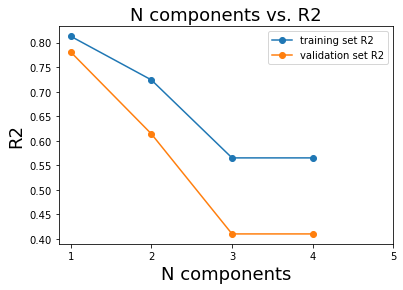

In [14]:
font = {'size': 18}
n_c = []
for x in range(1, len(Y_train.columns)+2):
    model = CCA(n_components=x)
    model.fit(Z_train, Y_train)
    n_c += [[x, round(model.score(Z_train, Y_train), 3), round(model.score(Z_test, Y_test), 3)]]
n_c = pd.DataFrame(n_c, columns=['n_comp', 'R2cal', 'R2val'])
plt.plot(n_c.n_comp, n_c.R2cal, 'o-')
plt.plot(n_c.n_comp, n_c.R2val, 'o-')
plt.xlabel('N components', fontdict = font)
plt.xticks(np.arange(1, len(Y_train.columns)+3, 1.0))
plt.ylabel('R2', fontdict = font)
plt.title('N components vs. R2', fontdict = font)
plt.legend(['training set R2','validation set R2'])
plt.savefig('ncomponents_r2.jpg', dpi=200)

# Execute the code below to calculate the model

In [5]:
nc = int(input('Provide the number of canonical components: '))
model = CCA(n_components=nc)
model.fit(Z_train, Y_train)
Yt_pred = pd.DataFrame(model.predict(Z_train), columns=Y_train.columns, index=Y_train.index)
Yv_pred = pd.DataFrame(model.predict(Z_test), columns=Y_train.columns, index=Y_test.index)
rmse_of_cal = np.sqrt(metrics.mean_squared_error(Y_train, Yt_pred))
rmse_of_val = np.sqrt(metrics.mean_squared_error(Y_test, Yv_pred))
X_c, Y_c = model.transform(Z_train, Y_train) #create canonical variables

def score_it_cv(X,y,k_folds=5):
    from sklearn.model_selection import cross_val_predict
    from sklearn.metrics import r2_score
    y_p = cross_val_predict(estimator = model, X=X, y=y, cv=k_folds)
    cv_score = r2_score(y,y_p)
    print(str(k_folds) + " folds cv score: " + str(round(cv_score,3)))
    return cv_score


# training set

k_folds = int(input("Provide the number of k-folds for validation (i.e.: 5): "))
print("\nGlobal model statistics:")
print('\nTraining set: ')
print('R2 score: ', round(model.score(Z_train, Y_train), 3))
train_cv = score_it_cv(Z_train, Y_train, k_folds) #r2cv
print("RMSEc: ", round(rmse_of_cal, 3))

# validation set
print('\nValidation set: ')
print('R2 score: ', round(model.score(Z_test, Y_test), 3))
test_cv = score_it_cv(Z_test, Y_test, k_folds) #q2cv
print("RMSEv: ", round(rmse_of_val, 3))

print("Model equations (for each endpoint):")
for i in range(0, model.coef_.shape[1]):
    coe = model.coef_[:,i]
    print('\nY' +str(i+1)+ '= ')
    for co in range(0, len(coe)):
        print(str(round(coe[co],3))+' x '+ X_train.columns.values[co])

# statistics for each separate endpoint
print("\nStatistic for each predicted endpoint: ")
from sklearn.metrics import r2_score
for x in Y_train:
    print(x)
    print('R2 score: ', round(r2_score(Y_train[x], Yt_pred[x]), 3))
    print('Q2 score: ', round(r2_score(Y_test[x], Yv_pred[x]), 3))
    print('------------')


Provide the number of canonical components: 1
Provide the number of k-folds for validation (i.e.: 5): 5

Global model statistics:

Training set: 
R2 score:  0.813
5 folds cv score: 0.763
RMSEc:  0.407

Validation set: 
R2 score:  0.781
5 folds cv score: 0.745
RMSEv:  0.428
Model equations (for each endpoint):

Y1= 
0.531 x MLOGP
0.216 x mw
0.131 x chemical potential
0.133 x Mv

Y2= 
0.519 x MLOGP
0.211 x mw
0.128 x chemical potential
0.13 x Mv

Y3= 
0.638 x MLOGP
0.26 x mw
0.158 x chemical potential
0.16 x Mv

Statistic for each predicted endpoint: 
D. Magna
R2 score:  0.909
Q2 score:  0.893
------------
Fish Medaka
R2 score:  0.768
Q2 score:  0.806
------------
Algae 
R2 score:  0.761
Q2 score:  0.645
------------


# Execute cell below to generate predicted vs. observed plot

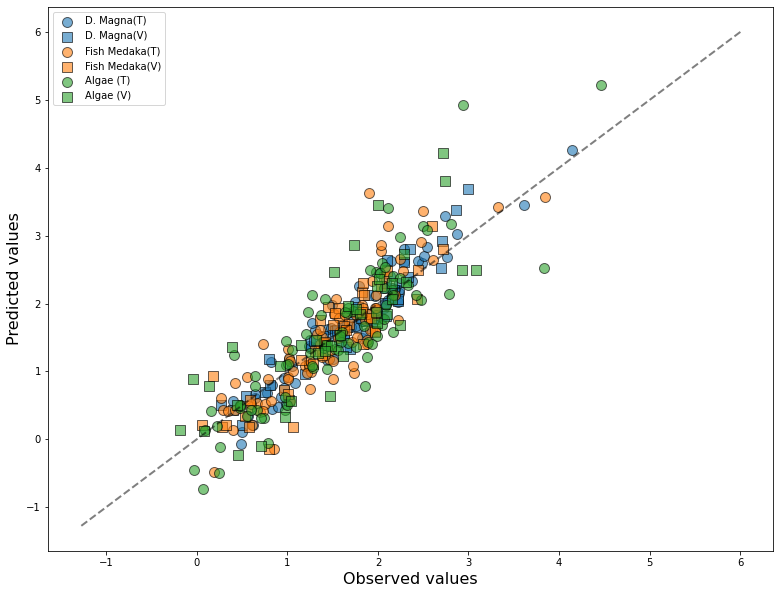

In [32]:
valpred = pd.DataFrame(model.predict(Z_test), columns=Y_test.columns+'_pred', index=Y_test.index)
valpred['Split']='Validation set'
calpred = pd.DataFrame(model.predict(Z_train),  columns=Y_train.columns+'_pred', index=Y_train.index)
calpred['Split']='Training set'
predicted = valpred.append(calpred)
standardized_observed = Z_test.append(Z_train)
standardized_observed.columns = standardized_observed.columns+'_std'
plt.figure(figsize=(13,10))


colors = ["tab:blue", "tab:orange", "tab:green", 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']
for x in range(0, len(Y.columns)):
    plt.scatter(Yt_pred.iloc[:,x], Y_train.iloc[:,x], s=100, edgecolor='k', alpha=0.6, c=colors[x], marker='o')
    plt.scatter(Yv_pred.iloc[:,x], Y_test.iloc[:,x], s=100, edgecolor='k', alpha=0.6, c=colors[x], marker='s')
    
leg = list()
for l in Y_train.columns.values:
    leg.append(str(l+'(T)'))
    leg.append(str(l+'(V)'))
    
plt.legend(leg)
p1 = max(predicted.iloc[:,0:len(Y.columns)].max().max(), Y.max().max())
p2 = min(predicted.iloc[:,0:len(Y.columns)].min().min(), Y.min().min())
plt.plot([p1, p2], [p1, p2], 'k--', lw=2, alpha=0.5)
plt.xlabel('Observed values', fontsize=16)
plt.ylabel('Predicted values', fontsize=16)
plt.savefig("pred_vs_obs.jpg", dpi=300)

# Execute cell below to generate loadings plot for each canonical variable

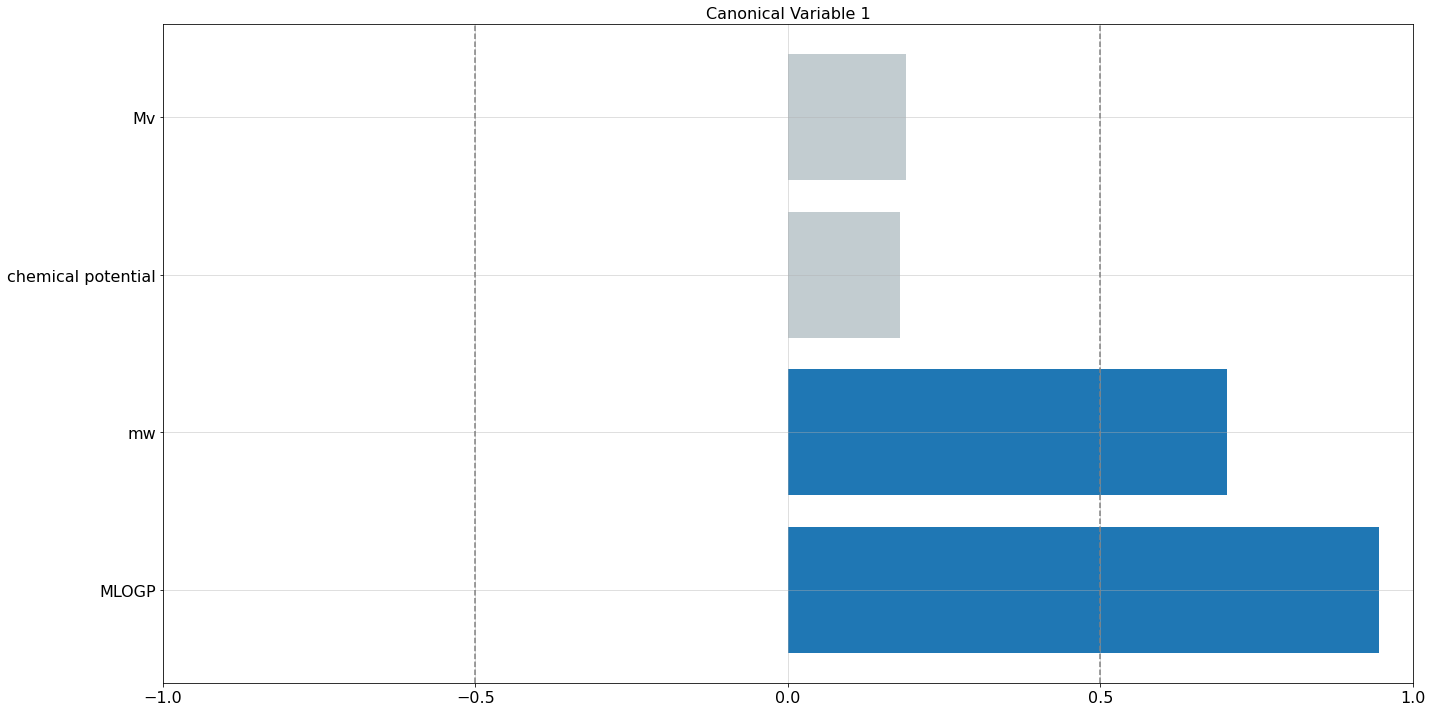

In [33]:
scores_id = list(range(X_c.shape[1]))
scores_names = list()
for x in scores_id:
    scores_names += ('CC'+ str(x+1) + ' ').split()
scores = pd.DataFrame(X_c, index=X_train.index, columns=scores_names)
Zscores=Z_train.join(scores)
Zscores_corr=Zscores.corr()
all_loadings = (Zscores_corr.iloc[len(X_train.columns):,:len(X_train.columns)]).T
loadings = all_loadings.iloc[:,:X_c.shape[1]]
col=[]
for x in range(0,len(loadings.columns)):
    for y in loadings.iloc[:,x]:
        if (y >= 0.5) or (y <= -0.5):
            col.append('tab:blue')
        else:
            col.append('#C2CCD0')
col2 = np.asarray(col)
col2 = col2.reshape(loadings.shape[1], loadings.shape[0])

# vertical barplot for loadings
y_pos = np.arange(len(loadings.index))
plt.figure(figsize=(20,10))
for x in range(0,len(loadings.columns)):
    plt.subplot(1, len(loadings.columns), x+1)
    plt.barh(y_pos, loadings.iloc[:,x], color=col2[x])
    plt.yticks(y_pos, loadings.index.values, fontsize=16)
    plt.xticks([-1,-0.5,0,0.5,1], fontsize=16)
    plt.axvline(-0.5, c='gray', linestyle='--')
    plt.axvline(0.5, c='gray', linestyle='--')
    plt.grid(alpha=0.5)
    plt.title('Canonical Variable '+ str(x+1), fontsize=16)
plt.tight_layout()    
plt.savefig('loadings.jpg', dpi=300)

# Applicability domain check by William's Plot (standardized residuals vs. leverages)

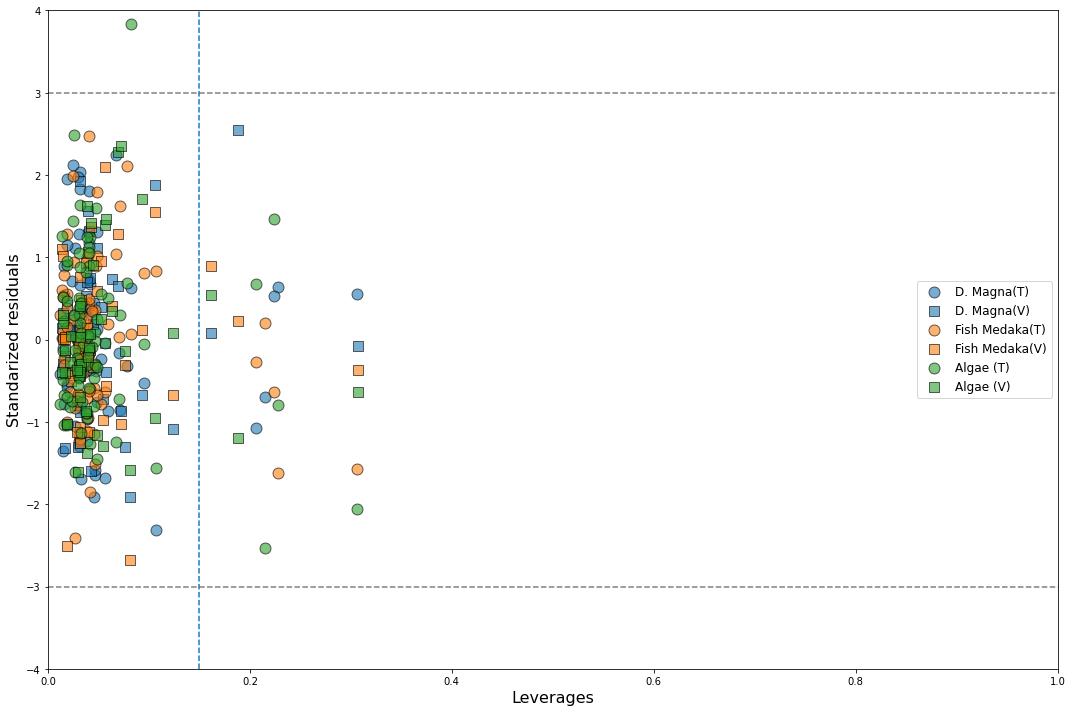

In [34]:
from numpy.linalg import matrix_power
from sklearn.preprocessing import StandardScaler 

font = {'size': 18}
st_residuals_train = scaler.fit_transform(Y_train - Yt_pred)
st_residuals_val = scaler.fit_transform(Y_test - Yv_pred)

h_k = (3 * len(X_train.columns))/len(X_train.index)

inner = matrix_power((np.dot(X_train.T,X_train)), -1)
h_indexes = []
for idx in X_train.index.values:
    xi_t = np.asarray(X_train.loc[idx]).T
    xi = np.asarray(X_train.loc[idx])
    hi = np.dot(xi_t.dot(inner), xi)
    h_indexes.append(hi)
    
h_indexes_v = []
for idx in X_test.index.values:
    xi_t = np.asarray(X_test.loc[idx]).T
    xi = np.asarray(X_test.loc[idx])
    hi_v = np.dot(xi_t.dot(inner), xi)
    h_indexes_v.append(hi_v)
    
plt.figure(figsize=(15,10))

colors = ["tab:blue", "tab:orange", "tab:green", 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']

for x in range(0, len(Y_train.columns)):
    plt.scatter(h_indexes, st_residuals_train[:,x], s=120, marker='o', edgecolors='k', c=colors[x], alpha=0.6)
    plt.scatter(h_indexes_v, st_residuals_val[:,x], s=120, marker='s', edgecolors='k', c=colors[x], alpha=0.6)

plt.ylim(-4, 4)
plt.xlim(right=1)
plt.xlim(left=0)

leg = list()
for l in Y_train.columns.values:
    leg.append(str(l+'(T)'))
    leg.append(str(l+'(V)'))
    
plt.legend(leg, loc='best', frameon=True, fontsize=12)
plt.xlabel('Leverages', fontsize=16)
plt.ylabel('Standarized residuals', fontsize=16)
plt.axhline(y=3, color='gray', linestyle='--')
plt.axhline(y=-3, color='gray', linestyle='--')
plt.axvline(x=h_k, linestyle='--')
plt.tight_layout()
plt.savefig('williams_ad.jpg', dpi=300)

# Results generation
### Code below transforms logarythmic values of of EC50. If your data does not require such transformation execute the cell below and give the answer "N"
### After execution, a file with results will be generated in the current folder.

In [8]:
transform = str(input("Transform the logEC50 values? (Y/N): "))
if transform.lower() == "y":
    pred_all = Yt_pred.append(Yv_pred)
    acute_all = pred_all
    mgl_all = Yt_pred.append(Yv_pred)
    for e in Y:
        for x in pred_all.index:    
            tox_class = calculate_acute_class(calculate_mg_l(pred_all.loc[x][e], mol_weights.loc[x]['molecular_weights']))
            mgl_all.loc[x][e]=calculate_mg_l(pred_all.loc[x][e], mol_weights.loc[x]['molecular_weights'])
            acute_all.loc[x][e]=tox_class
    acute_all.columns = acute_all.columns+'_acute_class'
    mgl_all.columns = mgl_all.columns+'_[mg/L]'
    print("Endpoint data transformed.")

    res_data = X.join(standardized_observed).join(predicted).join(acute_all)
    res_data['Alert_level']=res_data.iloc[:,-3:].sum(axis=1)

    res_data.to_excel('results_data.xlsx')
    print("Data saved to 'results_data.xlsx' file.")
else:
    pred_all = Yt_pred.append(Yv_pred)
    acute_all = pred_all
    mgl_all = Yt_pred.append(Yv_pred)
    for e in Y:
        for x in pred_all.index:    
            tox_class = calculate_acute_class(pred_all.loc[x][e])
            acute_all.loc[x][e]=tox_class
    acute_all.columns = acute_all.columns+'_acute_class'
    mgl_all.columns = mgl_all.columns+'_[mg/L]'
    print("Endpoint data NOT transformed.")
    res_data = X.join(standardized_observed).join(predicted).join(acute_all)
    res_data['Alert_level']=res_data.iloc[:,-3:].sum(axis=1)

    res_data.to_excel('results_data_no_transformation.xlsx')
    print("Data saved to 'results_data_no_transformation.xlsx' file.")


Transform the logEC50 values? (Y/N): Y
Endpoint data transformed.
Data saved to 'results_data.xlsx' file.
